In [7]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (16, 4)
from scipy.io.wavfile import read
from librosa import feature, frames_to_time, autocorrelate

## Tempo Estimation

The beat (or pulse) of a musical piece is a *periodic* sequence of events or impulses. By examining the periodic structure of the impluses, we can try to estimate what one period is (the distance of a beat), which will allow us to guess the tempo.

### Autocorrelation

We have learned about correlation. Autocorrelation is used to find how similar a signal, or function, is *to itself* at a certain time difference, which is referred to as *lag*.

For example, let's say I have the following sequence:

In [8]:

vals = np.array([4,1,3,1,4,1.5,2.5,0.2,3.5,1,2,1.5])

Let's make a plot to see it better:

/var/folders/jr/tf9k36ws1956sfj0w8ybnj2m0000gn/T/ipykernel_32513/1484092853.py:1: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(vals, use_line_collection=True)


<StemContainer object of 3 artists>

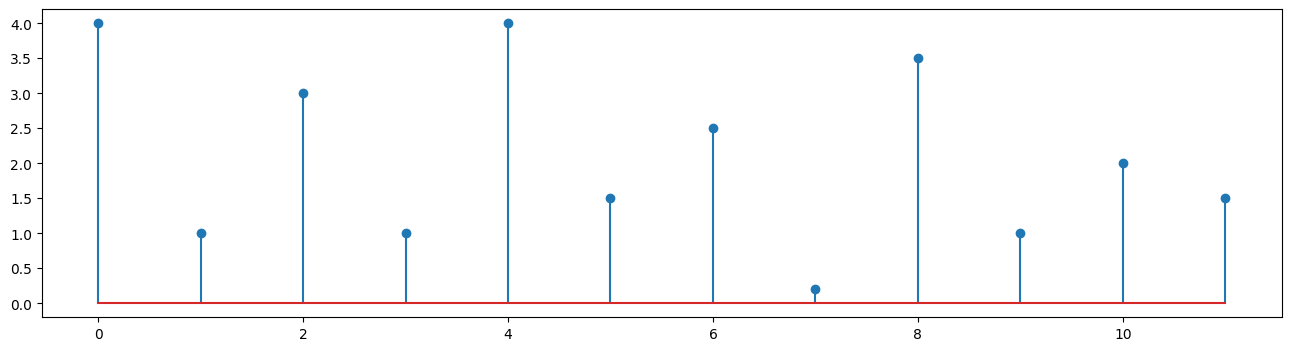

In [9]:
plt.stem(vals, use_line_collection=True)

An autocorrelation will compare this original array to every possible shifted version of itself.

/var/folders/jr/tf9k36ws1956sfj0w8ybnj2m0000gn/T/ipykernel_32513/3257953671.py:5: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(vals, use_line_collection=True)
/var/folders/jr/tf9k36ws1956sfj0w8ybnj2m0000gn/T/ipykernel_32513/3257953671.py:6: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  (markers, stemlines, baseline) = plt.stem(b, use_line_collection=True)


[None, None, None, None]

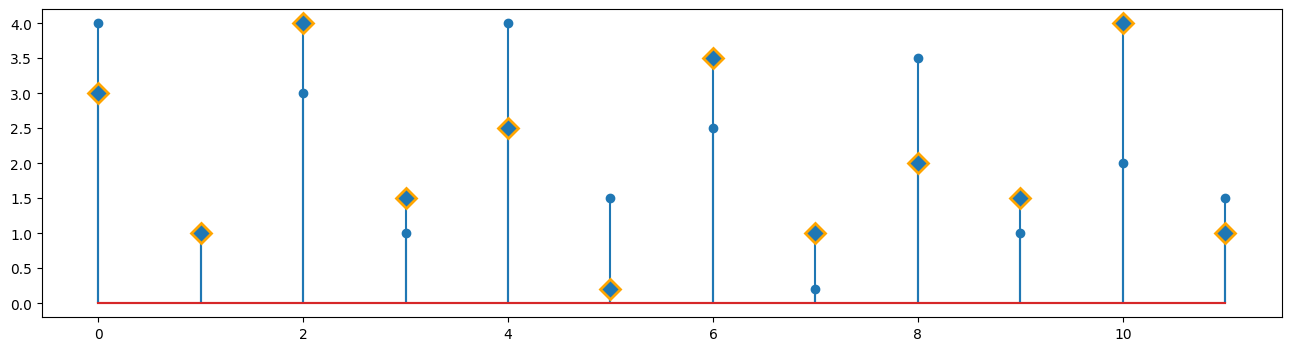

In [10]:
a = np.roll(vals, -1)
b = np.roll(vals, -2)
c = np.roll(vals, -4)

plt.stem(vals, use_line_collection=True)
(markers, stemlines, baseline) = plt.stem(b, use_line_collection=True)
plt.setp(markers, marker='D', markersize=10, markeredgecolor="orange", markeredgewidth=2)


In [11]:
np.corrcoef(vals, c)

array([[1.       , 0.8598234],
       [0.8598234, 1.       ]])

### Test it out on Energy values

In [12]:
(fs, x) = read('../audio/80sPopDrums.wav')
xnorm = x/np.abs(x.max())

In [13]:
time = np.arange(0,xnorm.size/fs,1/fs)

hop_length = 512 # 50% overlap
frame_length = 1024

In [14]:
energy = feature.rms(xnorm, hop_length=hop_length, frame_length=frame_length)

/var/folders/jr/tf9k36ws1956sfj0w8ybnj2m0000gn/T/ipykernel_32513/1649945234.py:1: FutureWarning: Pass y=[ 0.         -0.00112674 -0.00112674 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  energy = feature.rms(xnorm, hop_length=hop_length, frame_length=frame_length)


In [15]:
len(energy[0])

752

In [16]:
frames = range(len(energy[0]))
t = frames_to_time(frames, sr=fs, hop_length=hop_length)

In [17]:
t.shape

(752,)

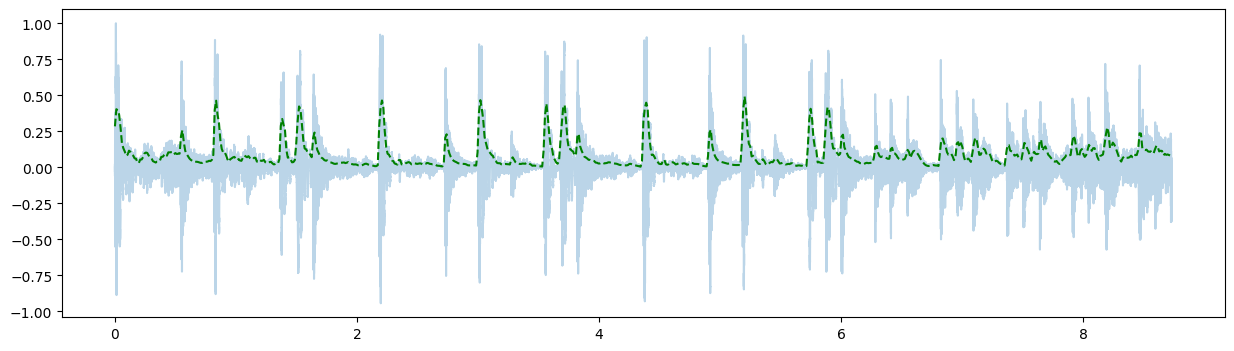

In [18]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,4))

plt.plot(time, xnorm, alpha=0.3)
plt.plot(t, energy[0], 'g--');

In [19]:
diff = energy[0][1:] - energy[0][0:-1]
#half-wave rectification - use numpy.where to set elements of array when condition is satisfied
diff = np.where(diff < 0, 0, diff)
#diff[diff < 0 ] = 0

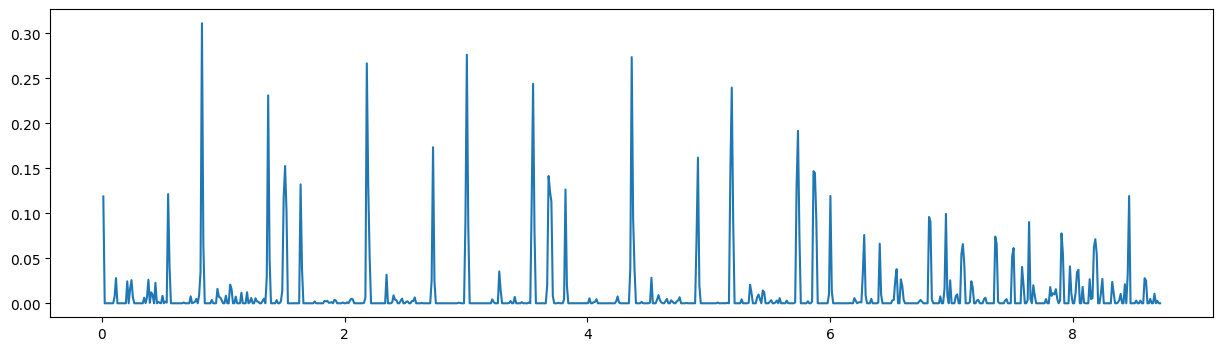

In [20]:
plt.figure(figsize=(15,4))
plt.plot(t[1:], diff);


In [21]:
xplines = diff > 0.03
xplines[:20]

array([ True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False])

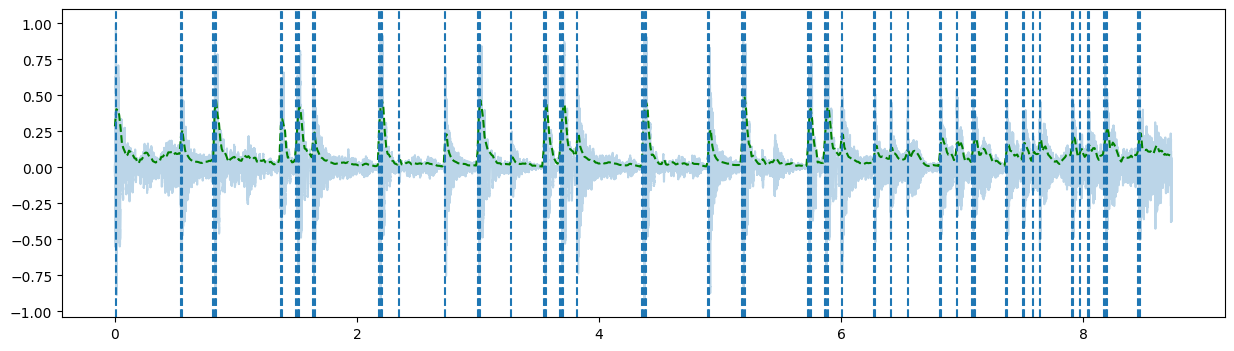

In [22]:
plt.figure(figsize=(15,4))

plt.plot(time, xnorm, alpha=0.3)
plt.plot(t, energy[0], 'g--');

for xc in t[1:][xplines]:
    plt.axvline(x=xc, linestyle='--')

We can use `librosa.clicks` to check how we are doing (https://librosa.org/doc/0.8.0/generated/librosa.clicks.html)


In [23]:
import librosa
clicks = librosa.clicks(times=t[1:][xplines], sr=fs, hop_length=None)

In [24]:
print(xnorm.size, clicks.size)

384993 377658


In [25]:
clicks.resize(xnorm.shape)
combn = clicks + xnorm

In [26]:
from IPython.display import Audio

In [27]:
Audio(combn, rate=fs)

In [28]:
ac = librosa.autocorrelate(diff)

Text(0.5, 0, 'Time lag (in frames)')

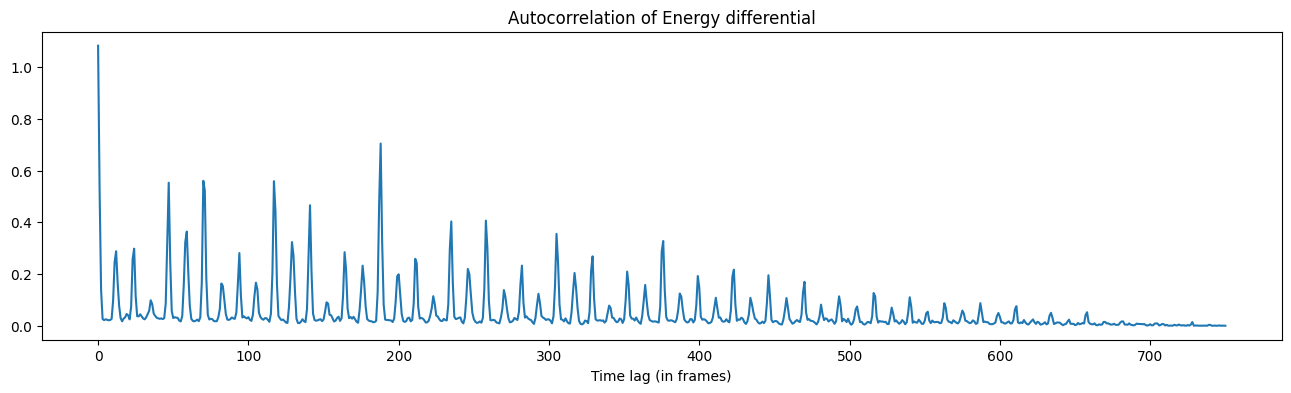

In [29]:
plt.plot(ac)
plt.title('Autocorrelation of Energy differential')
plt.xlabel('Time lag (in frames)')

In [30]:
ac.max()

1.0824595377261215

In [31]:
ac[0]

1.0824595377261215

In [32]:
v = ac[1:].max()
v

0.7043166239738892

In [33]:
points = np.where(ac > 0.4) #ignore zero and one
points

(array([  0,   1,  47,  70,  71, 117, 118, 141, 187, 188, 235, 258]),)

Calculate the times between successive spikes (each frame increments by 512 samples).

In [34]:
fsec = 512/fs
fsec

0.011609977324263039

In [35]:
points = np.array(points)
t_inc = fsec * points
#ignore first two values (zero and one)
t_inc[0][2:]

array([0.54566893, 0.81269841, 0.82430839, 1.35836735, 1.36997732,
       1.6370068 , 2.17106576, 2.18267574, 2.72834467, 2.99537415])

In [36]:
#calculate the differences between the values
ts = t_inc[0][2:]

ts[1:] - ts[:-1]

array([0.26702948, 0.01160998, 0.53405896, 0.01160998, 0.26702948,
       0.53405896, 0.01160998, 0.54566893, 0.26702948])

Notice that .011, .276, and .534 (approximately) recur (in seconds). 60 divided by these values gets us estimated tempo

In [37]:
tempa = 60 / .011
tempb = 60 / .267
tempc = 60 / .534

print( tempa, tempb, tempc)

5454.545454545455 224.7191011235955 112.35955056179775


Given the "normal" range of tempi, tempc is the most likely. Check with tempo calculator.